import 라이브러리

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Activation

데이터 읽기

In [3]:
f_topo = '2002-2004_topo.csv'
f_station = '2002-2004_station.csv'

topo = pd.read_csv(f_topo, encoding='cp949')
station = pd.read_csv(f_station, encoding='cp949')

topo.head(), station.head()

(   Longitude (°E)  Depth (meter)
 0      130.930214           0.00
 1      130.934429         323.45
 2      130.938643         428.52
 3      130.942857         536.27
 4      130.947071         644.44,
   Station name  Longitude (°E)  Latitude (°N)
 0           U1          131.11      37.397933
 1           U2          131.26      37.356567
 2      U3(EC1)          131.43      37.318933
 3           U4          131.66      37.298867
 4           U5          131.72      37.294683)

지점별 면적 계산

In [4]:
sta_lon = list(station.iloc[:, 1])
sta_lat = list(station.iloc[:, 2])

sta_width, sta_thickness = [], []
for i in range(0, 3):
    sta_width.append(sta_lon[i+1] - sta_lon[i])
    sta_thickness.append(abs(sta_lat[+1] - sta_lat[i]))

width = []
for j, k in zip(sta_width, sta_lat):
    width.append((2 * math.pi * 6400 * math.cos(k) / 360) * j) # 경도 1도(km) = 2 x 파이 x 지구 반지름 x cos(위도) / 360

zero = 1500
height = [(2090-zero)*0.001, (2250-zero)*0.001, (2235-zero)*0.001] # 높이

area = []
for l, m in zip(width, height):
    area.append(l * m) # 면적

area

[9.440572301837701, 13.414473391447409, 17.534785225617426]

지점별 수송량 계산 후 csv로 저장

In [5]:
#2002-2004 지점 별 데이터 xls -> csv 변환 후 진행
f_u1a = '2002-2004_U1a.csv'
f_u1b = '2002-2004_U1b.csv'
f_u2a = '2002-2004_U2a.csv'
f_u2b = '2002-2004_U2b.csv'
f_u3a = '2002-2004_U3a.csv'
f_u3b = '2002-2004_U3b.csv'
f_list = [f_u1a, f_u1b, f_u2a, f_u2b, f_u3a, f_u3b]

sv_1a, sv_1b, sv_2a, sv_2b, sv_3a, sv_3b = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
sv_1a = area[0] * pd.read_csv(f_list[0]).iloc[:, -1]
sv_1b = area[0] * pd.read_csv(f_list[1]).iloc[:, -1]
sv_2a = area[1] * pd.read_csv(f_list[2]).iloc[:, -1]
sv_2b = area[1] * pd.read_csv(f_list[3]).iloc[:, -1]
sv_3a = area[2] * pd.read_csv(f_list[4]).iloc[:, -1]
sv_3b = area[2] * pd.read_csv(f_list[5]).iloc[:, -1]

sv_1a.to_csv('sv_1a.csv', index=False)
sv_1b.to_csv('sv_1b.csv', index=False)
sv_2a.to_csv('sv_2a.csv', index=False)
sv_2b.to_csv('sv_2b.csv', index=False)
sv_3a.to_csv('sv_3a.csv', index=False)
sv_3b.to_csv('sv_3b.csv', index=False)

결측치 처리 (미완성)

[[[11.]
  [ 4.]
  [22.]]

 [[11.]
  [ 4.]
  [23.]]

 [[11.]
  [ 5.]
  [ 0.]]

 ...

 [[11.]
  [11.]
  [ 5.]]

 [[11.]
  [11.]
  [ 6.]]

 [[11.]
  [11.]
  [ 7.]]] [[-5.15506572]
 [-4.94706897]
 [-5.11761765]
 ...
 [-1.2238949 ]
 [ 0.20079578]
 [-0.26005395]]


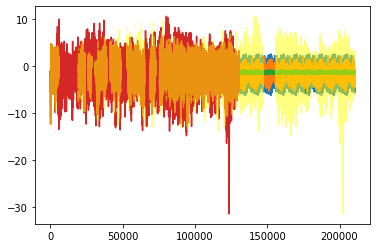

In [12]:
file = '1996-2020_U3.csv'

df = pd.read_csv(file, encoding='cp949')
df = df.drop(['Station', 'Year', 'Minute', 'Second', 'Depth (meter)'], axis=1)

df_1 = df.dropna(subset=df.columns[-1])

x_tr = df_1.iloc[:, 0:3]
y_tr = df_1.iloc[:, -1]

x_test = df.iloc[:, 0:3]
y_test = df.iloc[:, -1]

#RF
model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=42)
model.fit(x_tr, y_tr)
pred = model.predict(x_test)

#XGB
model2 = XGBRegressor(n_estimators=50, random_state=42)
model2.fit(x_tr, y_tr)
pred2 = model2.predict(x_test)

#LinearRegression
model3 = LinearRegression(fit_intercept=True)
model3.fit(x_tr, y_tr)
pred3 = model3.predict(x_test)

#KNN
y_test_4 = np.expand_dims(y_test, axis=0)

model4 = KNNImputer(n_neighbors=5)
pred4 = model4.fit_transform(y_test_4)
pred4 = np.transpose(pd.DataFrame(pred4))


x_tr_3 = np.expand_dims(x_tr, -1).astype('float')
y_tr_3 = np.expand_dims(y_tr, -1).astype('float')
x_test_3 = np.expand_dims(x_test, -1).astype('float')

#LSTM
# model5 = Sequential()
# model5.add(CuDNNLSTM(50, return_sequences=True))
# model5.add(CuDNNLSTM(1, return_sequences=False))
# model5.add(Activation('sigmoid'))
# model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model5.fit(x_tr_3, y_tr_3, epochs=100, batch_size=64)
# pred5 = model5.predict(x_test_3)


plt.plot(pred)
plt.plot(pred2)
plt.plot(pred3)
plt.plot(pred4)
# plt.plot(pred5)
plt.plot(y_test, alpha=0.5, color='yellow')
plt.show()

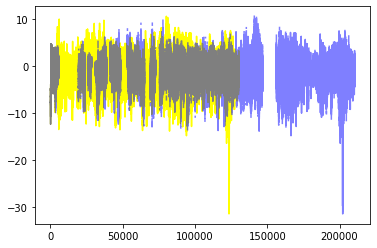

In [7]:
plt.plot(pred4, color='yellow')
plt.plot(y_test, alpha=0.5, color='blue')
plt.show()

In [8]:
pred4.shape, y_test.shape

((130404, 1), (210538,))

In [9]:
np.sum(y_test.isna())

80134

In [10]:
210538-130404

80134